<a href="https://colab.research.google.com/github/ramana16/EVA4/blob/master/EVA4S9/S9-Quiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from datetime import datetime
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2020-05-30 17:14:17.902960


In [0]:

%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/')

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from config import ModelConfig
from models.QuizDNN import QuizDNN
from train import train
from results import plot_misclassified_images, plot_graph
from utilities import *
from data_engine import DataEngine
from gradcam.visualize import VisualizeCam
#from test import test

# View model config
args = ModelConfig()
args.print_config()

print()
# Set seed
init_seed(args)

data = DataEngine(args)

Mounted at /content/gdrive/
Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout': 0.15,
  'epochs': 35,
  'l1_decay': 3e-06,
  'l2_decay': 0.001,
  'lr': 0.1,
  'max_lr': 0.01,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}

CUDA Available
Files already downloaded and verified
Files already downloaded and verified


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



plane   dog  deer  deer


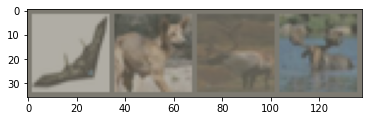

In [0]:
# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))





In [0]:
device = which_device()
net = QuizDNN(args)
model = net.to(device)
show_model_summary(model, (3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        MaxPool2d-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          36,864
             ReLU-14           [-1, 64,

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
scheduler = OneCycleLR(optimizer, max_lr=args.max_lr, epochs=args.epochs,
                       steps_per_epoch=len(data.train_loader))

def test(model, device, test_loader, criterion, classes, test_losses, test_accs,
         misclassified_imgs, correct_imgs, is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss +=criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              misclassified_inds = (is_correct==0).nonzero()[:,0]
              for mis_ind in misclassified_inds:
                if len(misclassified_imgs) == 25:
                  break
                misclassified_imgs.append({
                    "target": target[mis_ind].cpu().numpy(),
                    "pred": pred[mis_ind][0].cpu().numpy(),
                    "img": data[mis_ind]
                })
              
              correct_inds = (is_correct==1).nonzero()[:,0]
              for ind in correct_inds:
                if len(correct_imgs) == 25:
                  break
                correct_imgs.append({
                    "target": target[ind].cpu().numpy(),
                    "pred": pred[ind][0].cpu().numpy(),
                    "img": data[ind]
                })
            correct += is_correct.sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    test_acc = 100. * correct / len(test_loader.dataset)
    test_accs.append(test_acc)

    if test_acc > 85.0:
        classwise_acc(model, device, test_loader, classes)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))

def classwise_acc(model, device, test_loader, classes):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # print class-wise test accuracies
    print()
    for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))
    print()

def run(l1_decay=0.0, l2_decay=0.0):
  test_losses = []
  test_accs = []
  misclassified_imgs = []
  correct_imgs = []
  for epoch in range(args.epochs):
      print("EPOCH:", epoch+1)
      train(model, device, data.train_loader, criterion, optimizer, epoch, l1_decay, l2_decay, scheduler)
      test(model, device, data.test_loader, criterion, data.classes, test_losses, test_accs,
           misclassified_imgs, correct_imgs, epoch==args.epochs-1)
  return test_losses, test_accs, misclassified_imgs, correct_imgs



Let us show some of the training images, for fun.



In [0]:
# train and test the model
test_losses, test_accs, misclassified_imgs, correct_imgs = run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)


  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


L2_loss=116.40142059326172 L1_loss=6906.53173828125 Loss=1.9224933385849 Batch_id=781 Accuracy=38.35: 100%|██████████| 782/782 [00:31<00:00, 25.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0223, Accuracy: 4842/10000 (48.42%)

EPOCH: 2


L2_loss=117.66572570800781 L1_loss=6925.1171875 Loss=0.8010777831077576 Batch_id=781 Accuracy=54.70: 100%|██████████| 782/782 [00:30<00:00, 25.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0181, Accuracy: 5741/10000 (57.41%)

EPOCH: 3


L2_loss=119.35523223876953 L1_loss=6989.18798828125 Loss=1.3005684614181519 Batch_id=781 Accuracy=62.68: 100%|██████████| 782/782 [00:30<00:00, 25.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0172, Accuracy: 6060/10000 (60.60%)

EPOCH: 4


L2_loss=121.5069580078125 L1_loss=7119.0654296875 Loss=1.348716139793396 Batch_id=781 Accuracy=68.30: 100%|██████████| 782/782 [00:30<00:00, 26.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0136, Accuracy: 6924/10000 (69.24%)

EPOCH: 5


L2_loss=124.01900482177734 L1_loss=7317.13623046875 Loss=0.7289813160896301 Batch_id=781 Accuracy=72.86: 100%|██████████| 782/782 [00:30<00:00, 25.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0126, Accuracy: 7164/10000 (71.64%)

EPOCH: 6


L2_loss=126.61907196044922 L1_loss=7566.47509765625 Loss=0.8218823671340942 Batch_id=781 Accuracy=76.56: 100%|██████████| 782/782 [00:30<00:00, 25.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0121, Accuracy: 7375/10000 (73.75%)

EPOCH: 7


L2_loss=129.1123504638672 L1_loss=7830.072265625 Loss=0.9850464463233948 Batch_id=781 Accuracy=79.20: 100%|██████████| 782/782 [00:30<00:00, 25.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0108, Accuracy: 7646/10000 (76.46%)

EPOCH: 8


L2_loss=131.47805786132812 L1_loss=8101.96630859375 Loss=0.6192244291305542 Batch_id=781 Accuracy=80.95: 100%|██████████| 782/782 [00:29<00:00, 26.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0099, Accuracy: 7813/10000 (78.13%)

EPOCH: 9


L2_loss=133.58377075195312 L1_loss=8364.447265625 Loss=0.9618259072303772 Batch_id=781 Accuracy=82.58: 100%|██████████| 782/782 [00:30<00:00, 25.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0087, Accuracy: 8121/10000 (81.21%)

EPOCH: 10


L2_loss=135.58851623535156 L1_loss=8619.1201171875 Loss=0.6853283047676086 Batch_id=781 Accuracy=83.90: 100%|██████████| 782/782 [00:30<00:00, 25.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0082, Accuracy: 8201/10000 (82.01%)

EPOCH: 11


L2_loss=137.41360473632812 L1_loss=8864.443359375 Loss=0.5451393723487854 Batch_id=781 Accuracy=84.89: 100%|██████████| 782/782 [00:30<00:00, 25.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0081, Accuracy: 8265/10000 (82.65%)

EPOCH: 12


L2_loss=139.09725952148438 L1_loss=9099.578125 Loss=0.6563658118247986 Batch_id=781 Accuracy=85.57: 100%|██████████| 782/782 [00:30<00:00, 25.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0077, Accuracy: 8353/10000 (83.53%)

EPOCH: 13


L2_loss=140.63900756835938 L1_loss=9312.126953125 Loss=0.9953829050064087 Batch_id=781 Accuracy=86.51: 100%|██████████| 782/782 [00:30<00:00, 25.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0073, Accuracy: 8431/10000 (84.31%)

EPOCH: 14


L2_loss=142.0260772705078 L1_loss=9509.6982421875 Loss=0.9397623538970947 Batch_id=781 Accuracy=87.06: 100%|██████████| 782/782 [00:30<00:00, 25.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0077, Accuracy: 8341/10000 (83.41%)

EPOCH: 15


L2_loss=143.32362365722656 L1_loss=9685.4423828125 Loss=0.6267772912979126 Batch_id=781 Accuracy=87.98: 100%|██████████| 782/782 [00:30<00:00, 25.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 8460/10000 (84.60%)

EPOCH: 16


L2_loss=144.47019958496094 L1_loss=9852.271484375 Loss=0.7149507403373718 Batch_id=781 Accuracy=88.55: 100%|██████████| 782/782 [00:30<00:00, 25.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0078, Accuracy: 8327/10000 (83.27%)

EPOCH: 17


L2_loss=145.53738403320312 L1_loss=10016.44921875 Loss=0.25873300433158875 Batch_id=781 Accuracy=88.71: 100%|██████████| 782/782 [00:30<00:00, 25.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0073, Accuracy: 8452/10000 (84.52%)

EPOCH: 18


L2_loss=146.4595947265625 L1_loss=10154.7890625 Loss=0.5647560954093933 Batch_id=781 Accuracy=89.59: 100%|██████████| 782/782 [00:30<00:00, 25.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 92 %
Accuracy of  bird : 72 %
Accuracy of   cat : 59 %
Accuracy of  deer : 79 %
Accuracy of   dog : 83 %
Accuracy of  frog : 91 %
Accuracy of horse : 93 %
Accuracy of  ship : 91 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0069, Accuracy: 8553/10000 (85.53%)

EPOCH: 19


L2_loss=147.22906494140625 L1_loss=10279.72265625 Loss=1.0788466930389404 Batch_id=781 Accuracy=90.14: 100%|██████████| 782/782 [00:30<00:00, 25.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 92 %
Accuracy of  bird : 77 %
Accuracy of   cat : 76 %
Accuracy of  deer : 91 %
Accuracy of   dog : 68 %
Accuracy of  frog : 85 %
Accuracy of horse : 83 %
Accuracy of  ship : 87 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0068, Accuracy: 8575/10000 (85.75%)

EPOCH: 20


L2_loss=147.9420166015625 L1_loss=10396.8896484375 Loss=0.31694644689559937 Batch_id=781 Accuracy=90.33: 100%|██████████| 782/782 [00:30<00:00, 25.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 94 %
Accuracy of  bird : 86 %
Accuracy of   cat : 68 %
Accuracy of  deer : 83 %
Accuracy of   dog : 80 %
Accuracy of  frog : 92 %
Accuracy of horse : 89 %
Accuracy of  ship : 93 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0067, Accuracy: 8622/10000 (86.22%)

EPOCH: 21


L2_loss=148.51161193847656 L1_loss=10499.212890625 Loss=1.1109551191329956 Batch_id=781 Accuracy=90.91: 100%|██████████| 782/782 [00:30<00:00, 25.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 96 %
Accuracy of  bird : 71 %
Accuracy of   cat : 70 %
Accuracy of  deer : 82 %
Accuracy of   dog : 80 %
Accuracy of  frog : 95 %
Accuracy of horse : 94 %
Accuracy of  ship : 93 %
Accuracy of truck : 81 %

Test set: Average loss: 0.0068, Accuracy: 8627/10000 (86.27%)

EPOCH: 22


L2_loss=149.0395050048828 L1_loss=10591.0439453125 Loss=0.2461460381746292 Batch_id=781 Accuracy=91.19: 100%|██████████| 782/782 [00:30<00:00, 25.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 98 %
Accuracy of  bird : 79 %
Accuracy of   cat : 79 %
Accuracy of  deer : 92 %
Accuracy of   dog : 81 %
Accuracy of  frog : 93 %
Accuracy of horse : 89 %
Accuracy of  ship : 90 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0065, Accuracy: 8694/10000 (86.94%)

EPOCH: 23


L2_loss=149.43994140625 L1_loss=10662.2998046875 Loss=0.8221723437309265 Batch_id=781 Accuracy=91.77: 100%|██████████| 782/782 [00:30<00:00, 25.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 95 %
Accuracy of  bird : 82 %
Accuracy of   cat : 75 %
Accuracy of  deer : 91 %
Accuracy of   dog : 85 %
Accuracy of  frog : 91 %
Accuracy of horse : 85 %
Accuracy of  ship : 94 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0064, Accuracy: 8650/10000 (86.50%)

EPOCH: 24


L2_loss=149.7910614013672 L1_loss=10723.8701171875 Loss=0.6459236145019531 Batch_id=781 Accuracy=92.05: 100%|██████████| 782/782 [00:30<00:00, 25.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 97 %
Accuracy of   car : 93 %
Accuracy of  bird : 76 %
Accuracy of   cat : 72 %
Accuracy of  deer : 92 %
Accuracy of   dog : 75 %
Accuracy of  frog : 88 %
Accuracy of horse : 91 %
Accuracy of  ship : 89 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0066, Accuracy: 8671/10000 (86.71%)

EPOCH: 25


L2_loss=149.97219848632812 L1_loss=10765.3056640625 Loss=0.7032139897346497 Batch_id=781 Accuracy=92.66: 100%|██████████| 782/782 [00:29<00:00, 26.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 97 %
Accuracy of  bird : 81 %
Accuracy of   cat : 78 %
Accuracy of  deer : 85 %
Accuracy of   dog : 79 %
Accuracy of  frog : 77 %
Accuracy of horse : 91 %
Accuracy of  ship : 86 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0065, Accuracy: 8672/10000 (86.72%)

EPOCH: 26


L2_loss=150.10833740234375 L1_loss=10797.5732421875 Loss=0.6150327920913696 Batch_id=781 Accuracy=92.94: 100%|██████████| 782/782 [00:30<00:00, 26.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 97 %
Accuracy of  bird : 81 %
Accuracy of   cat : 70 %
Accuracy of  deer : 84 %
Accuracy of   dog : 85 %
Accuracy of  frog : 90 %
Accuracy of horse : 84 %
Accuracy of  ship : 94 %
Accuracy of truck : 85 %

Test set: Average loss: 0.0062, Accuracy: 8691/10000 (86.91%)

EPOCH: 27


L2_loss=150.14857482910156 L1_loss=10813.712890625 Loss=0.3046914339065552 Batch_id=781 Accuracy=93.47: 100%|██████████| 782/782 [00:30<00:00, 25.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 90 %
Accuracy of  bird : 84 %
Accuracy of   cat : 84 %
Accuracy of  deer : 79 %
Accuracy of   dog : 77 %
Accuracy of  frog : 90 %
Accuracy of horse : 87 %
Accuracy of  ship : 81 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0063, Accuracy: 8715/10000 (87.15%)

EPOCH: 28


L2_loss=150.11936950683594 L1_loss=10817.181640625 Loss=0.48009568452835083 Batch_id=781 Accuracy=94.00: 100%|██████████| 782/782 [00:30<00:00, 25.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 97 %
Accuracy of   car : 98 %
Accuracy of  bird : 83 %
Accuracy of   cat : 77 %
Accuracy of  deer : 84 %
Accuracy of   dog : 84 %
Accuracy of  frog : 85 %
Accuracy of horse : 88 %
Accuracy of  ship : 91 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0063, Accuracy: 8735/10000 (87.35%)

EPOCH: 29


L2_loss=150.03616333007812 L1_loss=10812.9580078125 Loss=0.6055837273597717 Batch_id=781 Accuracy=94.58: 100%|██████████| 782/782 [00:30<00:00, 25.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 95 %
Accuracy of   car : 93 %
Accuracy of  bird : 80 %
Accuracy of   cat : 66 %
Accuracy of  deer : 88 %
Accuracy of   dog : 79 %
Accuracy of  frog : 94 %
Accuracy of horse : 87 %
Accuracy of  ship : 91 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0062, Accuracy: 8785/10000 (87.85%)

EPOCH: 30


L2_loss=149.91928100585938 L1_loss=10804.46484375 Loss=0.5094878673553467 Batch_id=781 Accuracy=94.98: 100%|██████████| 782/782 [00:30<00:00, 25.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 90 %
Accuracy of   car : 92 %
Accuracy of  bird : 80 %
Accuracy of   cat : 81 %
Accuracy of  deer : 93 %
Accuracy of   dog : 81 %
Accuracy of  frog : 85 %
Accuracy of horse : 83 %
Accuracy of  ship : 92 %
Accuracy of truck : 98 %

Test set: Average loss: 0.0061, Accuracy: 8799/10000 (87.99%)

EPOCH: 31


L2_loss=149.83555603027344 L1_loss=10793.2197265625 Loss=0.2382972538471222 Batch_id=781 Accuracy=95.38: 100%|██████████| 782/782 [00:30<00:00, 26.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 95 %
Accuracy of  bird : 83 %
Accuracy of   cat : 73 %
Accuracy of  deer : 79 %
Accuracy of   dog : 89 %
Accuracy of  frog : 93 %
Accuracy of horse : 88 %
Accuracy of  ship : 87 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0061, Accuracy: 8808/10000 (88.08%)

EPOCH: 32


L2_loss=149.75698852539062 L1_loss=10783.359375 Loss=0.3358108401298523 Batch_id=781 Accuracy=95.75: 100%|██████████| 782/782 [00:30<00:00, 25.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 98 %
Accuracy of  bird : 84 %
Accuracy of   cat : 75 %
Accuracy of  deer : 89 %
Accuracy of   dog : 86 %
Accuracy of  frog : 90 %
Accuracy of horse : 86 %
Accuracy of  ship : 93 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0060, Accuracy: 8844/10000 (88.44%)

EPOCH: 33


L2_loss=149.6947021484375 L1_loss=10777.1123046875 Loss=0.27254652976989746 Batch_id=781 Accuracy=95.99: 100%|██████████| 782/782 [00:30<00:00, 25.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 100 %
Accuracy of  bird : 89 %
Accuracy of   cat : 72 %
Accuracy of  deer : 86 %
Accuracy of   dog : 76 %
Accuracy of  frog : 91 %
Accuracy of horse : 86 %
Accuracy of  ship : 90 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0061, Accuracy: 8846/10000 (88.46%)

EPOCH: 34


L2_loss=149.67169189453125 L1_loss=10774.4453125 Loss=0.20836499333381653 Batch_id=781 Accuracy=96.18: 100%|██████████| 782/782 [00:30<00:00, 26.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 93 %
Accuracy of  bird : 95 %
Accuracy of   cat : 76 %
Accuracy of  deer : 91 %
Accuracy of   dog : 81 %
Accuracy of  frog : 85 %
Accuracy of horse : 91 %
Accuracy of  ship : 83 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0061, Accuracy: 8820/10000 (88.20%)

EPOCH: 35


L2_loss=149.66773986816406 L1_loss=10774.00390625 Loss=0.4118310213088989 Batch_id=781 Accuracy=96.41: 100%|██████████| 782/782 [00:30<00:00, 25.62it/s]



Accuracy of plane : 92 %
Accuracy of   car : 94 %
Accuracy of  bird : 93 %
Accuracy of   cat : 74 %
Accuracy of  deer : 89 %
Accuracy of   dog : 88 %
Accuracy of  frog : 88 %
Accuracy of horse : 88 %
Accuracy of  ship : 96 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0059, Accuracy: 8868/10000 (88.68%)



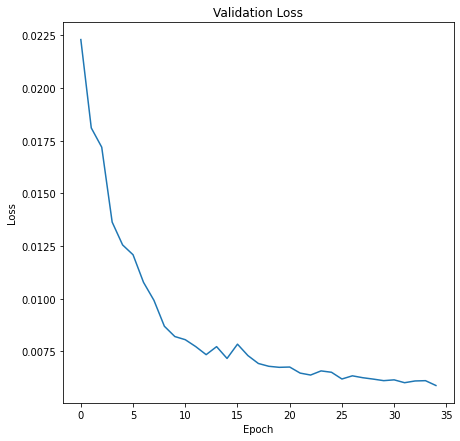

In [0]:
plot_graph(test_losses, "Loss")



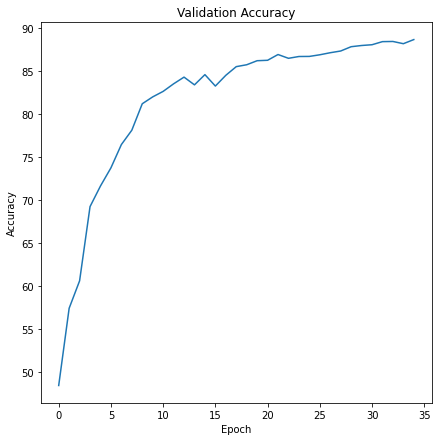

In [0]:
plot_graph(test_accs, "Accuracy")



In [0]:
plot_misclassified_images(misclassified_imgs, data.classes, "misclassified_imgs.png")

In [0]:
target_layers = ["x3_block","x5_block","x7_block","x11_block"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

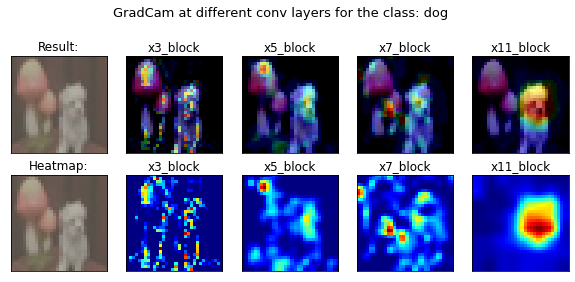

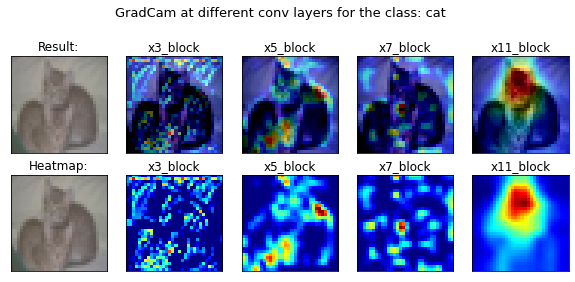

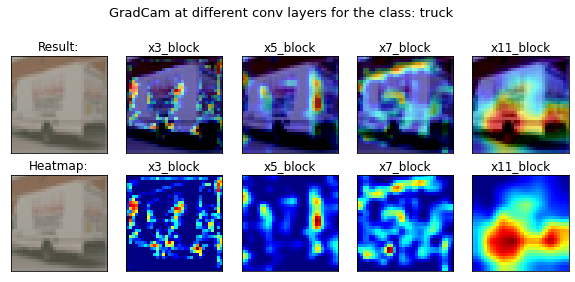

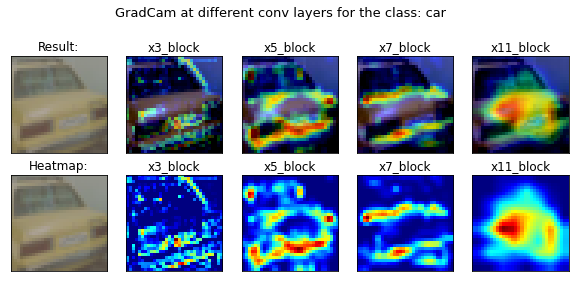

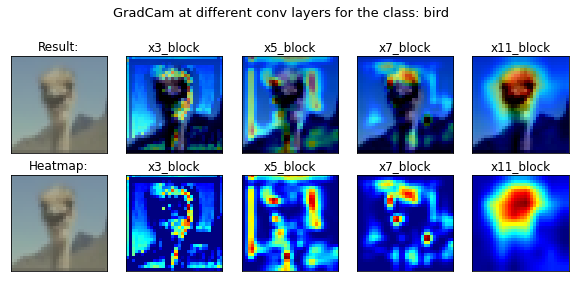

In [0]:
num_img = 5
correct_pred_imgs = []
for i in range(num_img):
  correct_pred_imgs.append(torch.as_tensor(correct_imgs[i]["img"]))
viz_cam(torch.stack(correct_pred_imgs), target_layers, metric="correct")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

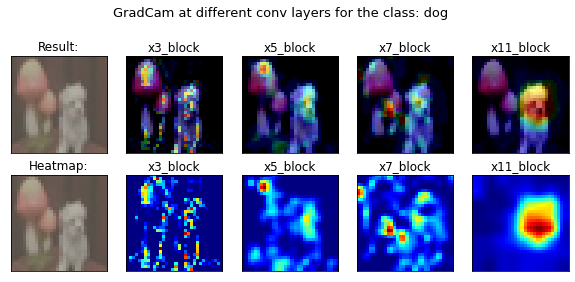

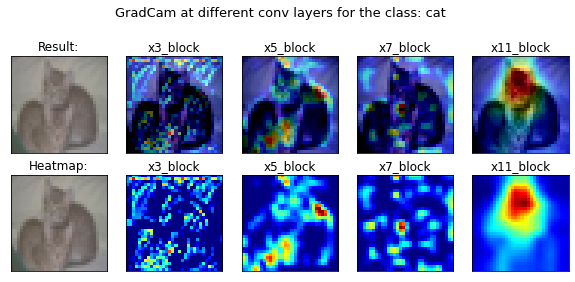

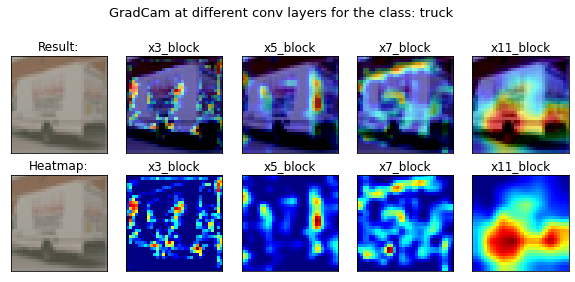

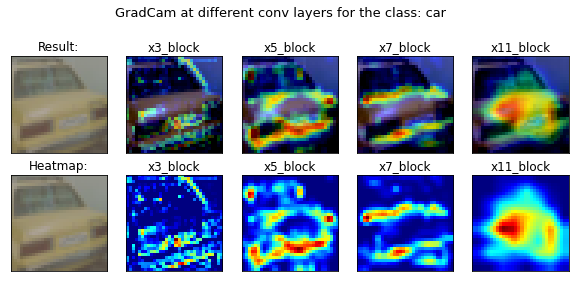

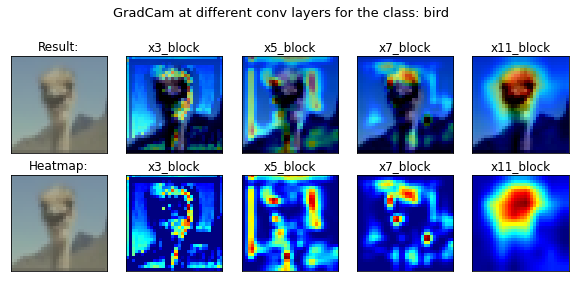

In [0]:
num_img = 5
correct_pred_imgs = []
for i in range(num_img):
  correct_pred_imgs.append(torch.as_tensor(correct_imgs[i]["img"]))
viz_cam(torch.stack(correct_pred_imgs), target_layers, metric="correct")